# 0.0 Tools

## 0.1. Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# import psycopg2 as pg
import scikitplot as skplt
import matplotlib.pyplot as plt
import os
import pickle
import inflection

from scipy                 import stats
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML

from xgboost import XGBClassifier
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

## 0.2. Load dataset

In [2]:
data = pd.read_csv('Data/train.csv')

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.3. Helper Functions

In [83]:
def cramer_v( x, y ):
    """Essa função implementa o cálculo da medida de associação conhecida como Cramér's V entre duas variáveis categóricas. 
       O Cramér's V é uma estatística que varia de 0 a 1, onde 0 indica nenhuma associação e 1 indica associação completa.
        O resultado final é a medida Cramér's V, que fornece uma indicação da força da associação entre as duas variáveis categóricas. 
        Quanto mais próximo o valor estiver de 0, menos associadas estão as variáveis, enquanto valores mais próximos de 1 indicam uma associação mais forte.
        A função recebe duas variáveis categóricas, x e y, e realiza os seguintes passos:
            1. Calcula a matriz de confusão (cm) entre as variáveis x e y usando pd.crosstab(x, y).
            2. Calcula a soma total dos valores na matriz de confusão (n).
            3. Obtém o número de linhas (r) e colunas (k) na matriz de confusão.
            4. Calcula o qui-quadrado (chi2) entre x e y usando ss.chi2_contingency(cm).
            5. Realiza correções nos valores do qui-quadrado (chi2corr, kcorr, rcorr) para levar em consideração o número de categorias em x e y.
            6. Calcula o Cramér's V.
    """
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = stats.chi2_contingency( cm )[0]   
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def corr_cramer_v(cat_attributes):
    '''
    Essa função, corr_cramer_v, calcula as correlações Cramér's V entre todas as combinações possíveis de variáveis categóricas em um DataFrame cat_attributes. 
    O resultado é um dicionário onde as chaves são as variáveis de referência e os valores associados são listas de correlações Cramér's V com todas as outras variáveis.
    A função segue os seguintes passos:
        1. Obtém a lista de nomes de colunas do DataFrame cat_attributes.
        2. Inicializa um dicionário vazio corr_dict que será usado para armazenar as correlações.
        3. Itera sobre todas as variáveis categóricas no DataFrame (usando cat_attributes_list).
        4. Para cada variável de referência, itera novamente sobre todas as variáveis categóricas e calcula a correlação Cramér's V usando a função cramer_v.
        5. As correlações são armazenadas em uma lista (corr_list), que é então associada à variável de referência no dicionário corr_dict.
        6. Ao final, o dicionário corr_dict é retornado, contendo as correlações Cramér's V entre todas as variáveis categóricas.
'''
    cat_attributes_list = cat_attributes.columns.tolist()
    corr_dict={}
    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict 



def precision_at_k(x_val, y_val, yhat, k_percentage=0.2):
    # copy data
    data = x_val.copy()
    data['response'] = y_val.copy()

    # propensity score
    data['score'] = yhat[:, 1].tolist()

    # sort clientes by propensiy score
    data = data.sort_values('score', ascending=False)
    
    # reset index
    data = data.reset_index(drop=True)
    
    # create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']           # predições corretas ate k / total de predições realizadas ate k
    
    k = np.round(k_percentage*data.shape[0]).astype(int)
    
    return data.loc[k, 'precision_at_k']



def recall_at_k(x_val, y_val, yhat, k_percentage=0.20):
    # copy data
    data = x_val.copy()
    data['response'] = y_val.copy()

    # propensity score
    data['score'] = yhat[:, 1].tolist()

    # sort clientes by propensiy score
    data = data.sort_values('score', ascending=False)
    
    # reset index
    data = data.reset_index(drop=True)
    
    # create ranking order
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()       # predições corretas ate k / total de exemplos verdadeiros ate k
    
    k = np.round(k_percentage*data.shape[0]).astype(int)
    
    return data.loc[k, 'recall_at_k']

# 1.0 Data Description

At this stage we will understand how the data is and how big the problem we are facing is.

In [5]:
df1 = data.copy()

## 1.1. Rename Columns

In [6]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
# data dimenstions
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Columns Description

* **id**	Unique ID for the customer
* **Gender**	Gender of the customer
* **Age**	Age of the customer
* **Driving_License**	0 : Customer does not have DL, 1 : Customer already has DL
* **Region_Code**	Unique code for the region of the customer
* **Previously_Insured**	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* **Vehicle_Age**	Age of the Vehicle
* **Vehicle_Damage**	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* **Annual_Premium**	The amount customer needs to pay as premium in the year
* **Policy_Sales_Channel**	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* **Vintage**	Number of Days, Customer has been associated with the company
* **Response**	1 : Customer is interested, 0 : Customer is not interested

## 1.6. Descriptive Statistical

In [10]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage',
                     'policy_sales_channel']]
target_attributes = df1['response']

### 1.6.1. Numerical Attributes

In [11]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


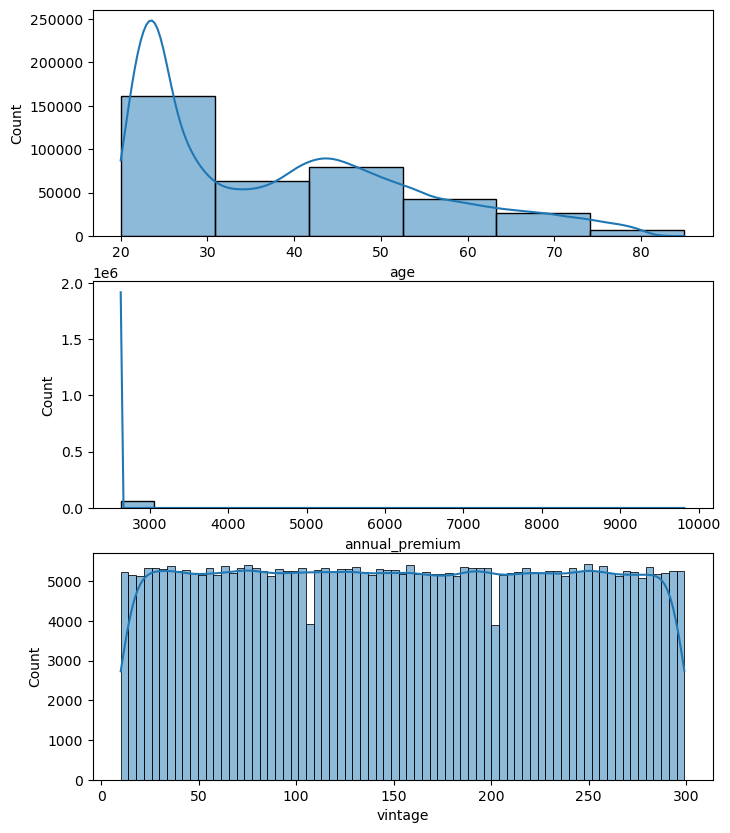

In [12]:
fig, axs = plt.subplots(3, figsize = (8, 10))
sns.histplot(df1['age'], ax=axs[0], bins = 6, kde=True)
sns.histplot(df1[df1['annual_premium']<10000]['annual_premium'], ax=axs[1], kde=True)
sns.histplot(df1['vintage'], ax=axs[2], kde=True);

### 1.6.2. Categorical Attributes

In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    155
dtype: int64

<Axes: xlabel='gender', ylabel='count'>

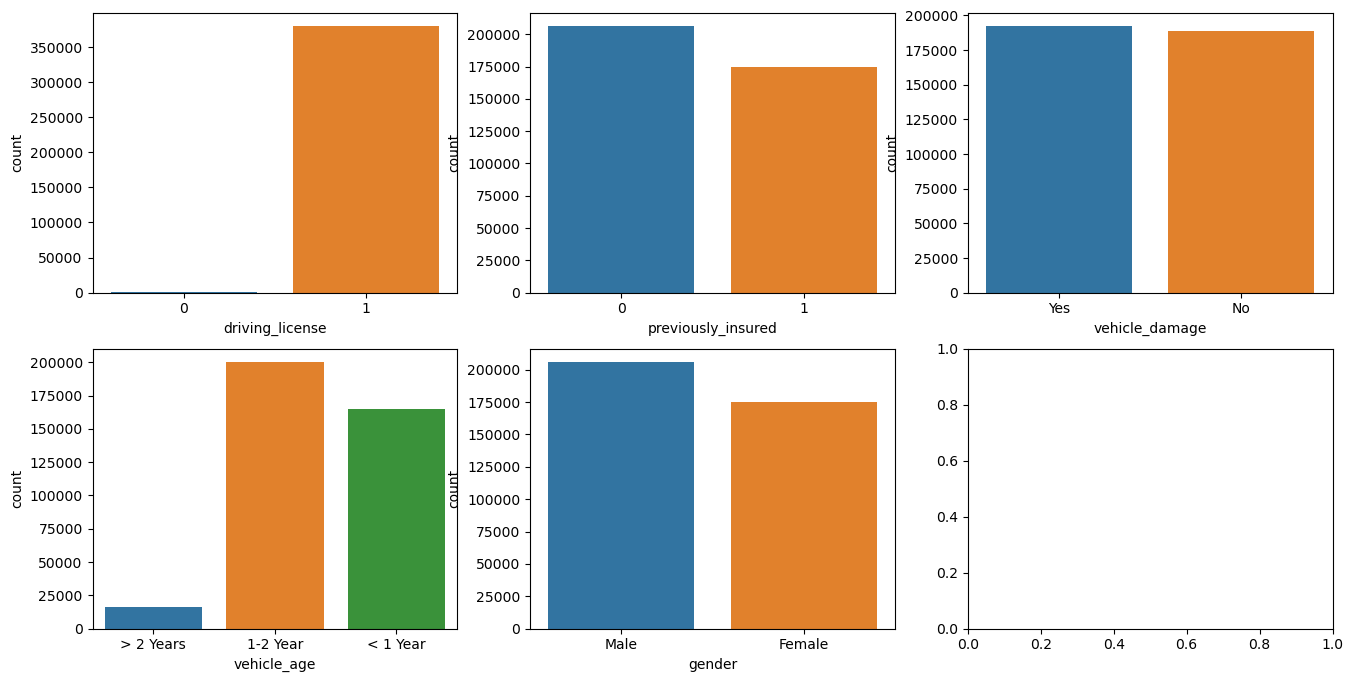

In [14]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (16, 8))

sns.countplot(x = 'driving_license', data = df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', data = df1, ax=axs[0][1])
sns.countplot(x = 'vehicle_damage', data = df1, ax=axs[0][2])
sns.countplot(x = 'vehicle_age', data = df1, ax=axs[1][0])
sns.countplot(x = 'gender', data = df1, ax=axs[1][1])

<Axes: xlabel='region_code', ylabel='count'>

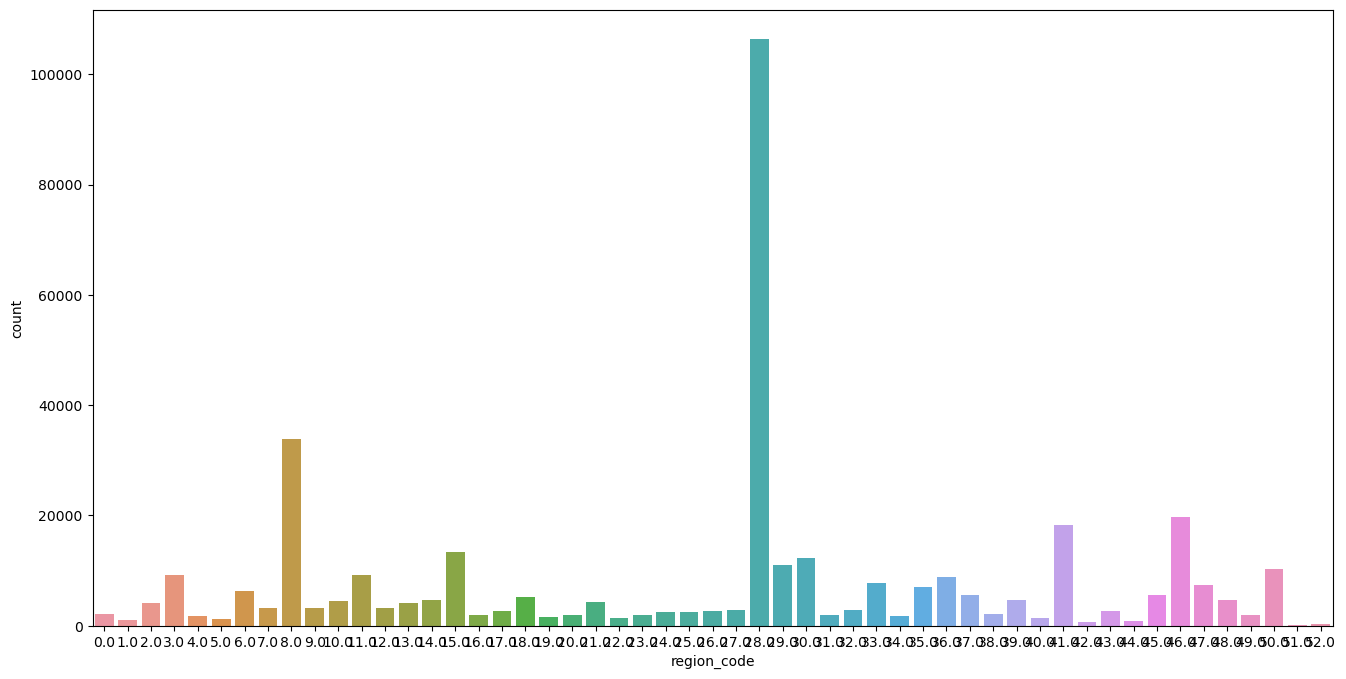

In [15]:
fig, axs = plt.subplots(figsize = (16, 8))
sns.countplot(x = 'region_code', data = df1)

<Axes: xlabel='policy_sales_channel', ylabel='count'>

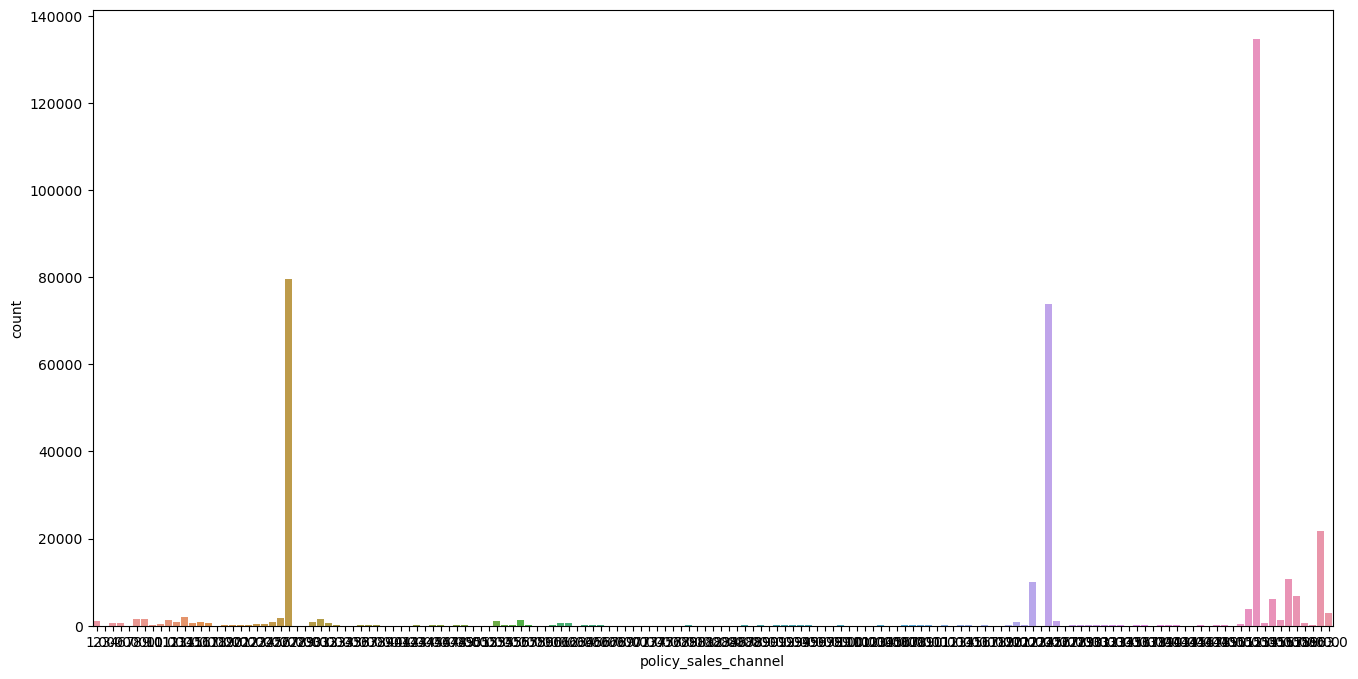

In [16]:
fig, axs = plt.subplots(figsize = (16, 8))
sns.countplot(x = 'policy_sales_channel', data = df1)

In [17]:
# Olhando pros 4 maiores valores:
df1['policy_sales_channel'].value_counts().head(4)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
Name: policy_sales_channel, dtype: int64

### 1.6.3 Target Atribute

<Axes: xlabel='response', ylabel='count'>

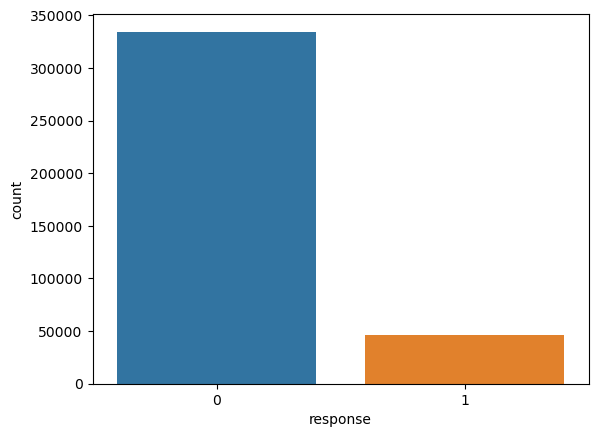

In [18]:
sns.countplot(x = 'response', data = df1)

# 2.0 Feature Engineering

In this step we will create features from existing variables.


## 2.1. Making Hypotesis

**1.** Male customers have more damaged vehicles

**2.** Male customers are more interested in buy vehicle insurance

**3.** Customers that pay less annual premium are more interested in buy vehicle insurance

**4.** Long time period customers are more insterested in buy vehicle insurance

**5.** Customers older than 36 are more interested in buy vehicle insurance

**6.** Customers with damaged vehicles are more interested in buy vehicle insurance

**7.** Customars with newer vehicles are more interested in buy vehicle insurance

**8.** Customers without driver license have no interest in buy vehicle insurance

**9.** Customers region code have no influence in the interest they have in buying vehicle insurance

**10**. Customers policy_sales_channel have no influence in the interest they have in buying vehicle insurance

## 2.2. Feature Engineering


In [19]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0 Data Filtering

At this stage, for now, we will not do any filtering on the data.

In [20]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

At this stage the objective is:

* Understand the business and generate insights.
* Find relevant variables for model learning.

In [21]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Age

C:\Users\leona\AppData\Local\Temp\ipykernel_7816\3131037003.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


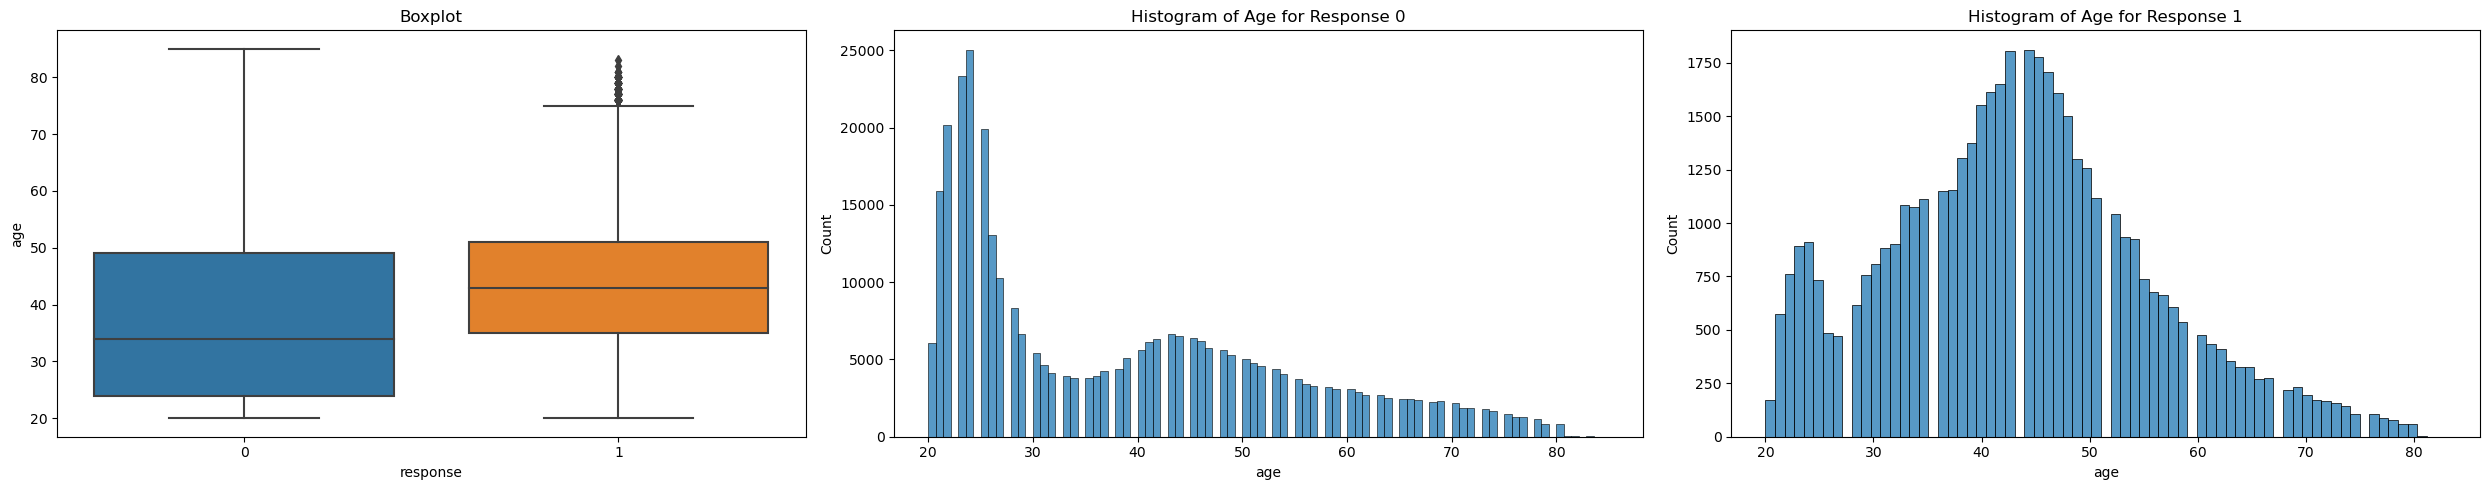

In [22]:
fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.boxplot( x='response', y='age', data=df4 )
plt.title('Boxplot')


# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(df4.loc[df4['response'] == 0, 'age'])
plt.title('Histogram of Age for Response 0')

# Subplot 2
plt.subplot(1, 3, 3)
sns.histplot(df4.loc[df4['response'] == 1, 'age'])
plt.title('Histogram of Age for Response 1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

### 4.1.2. Anual Income

C:\Users\leona\AppData\Local\Temp\ipykernel_7816\2250126909.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


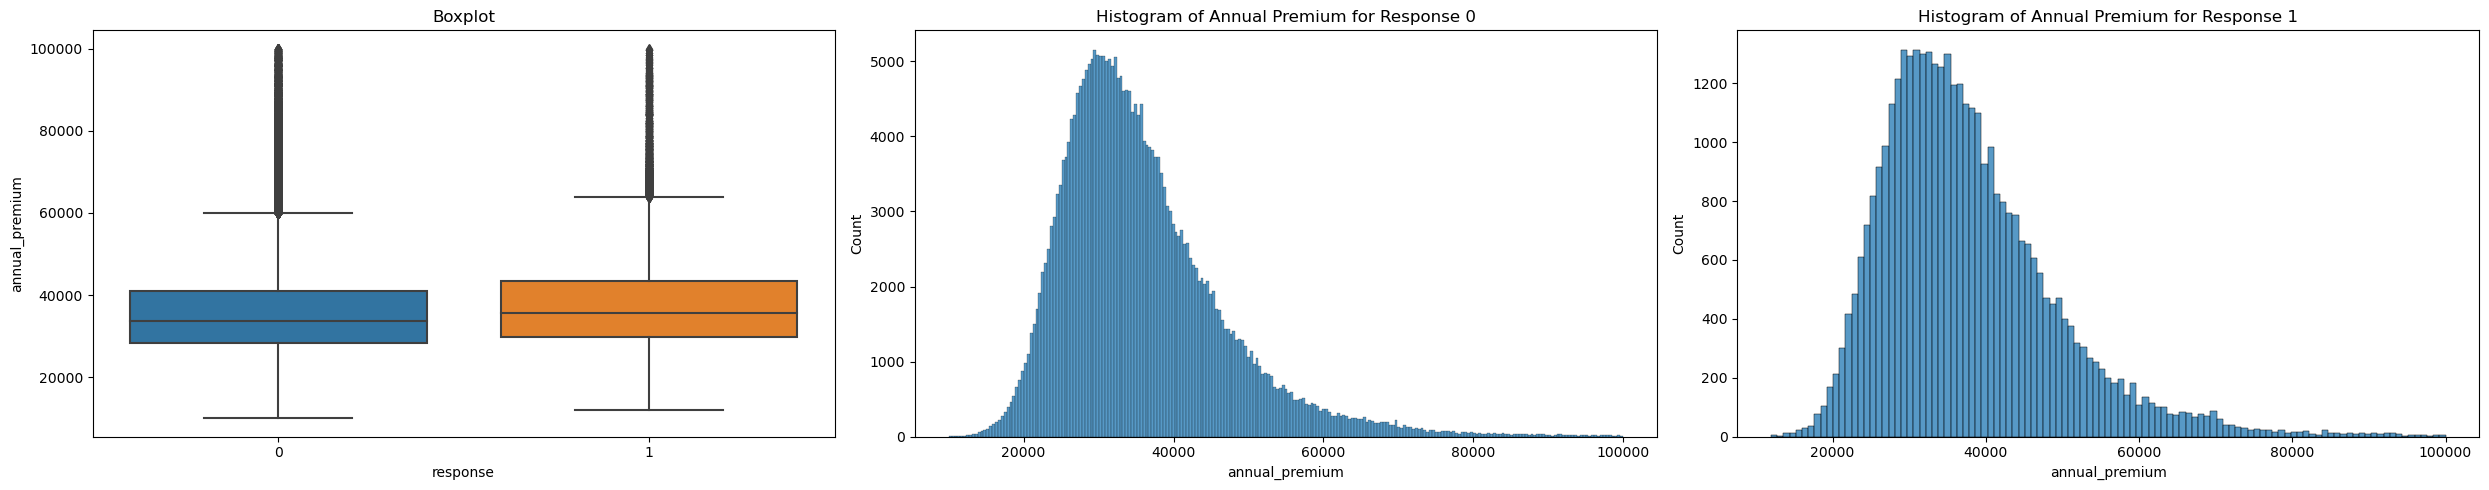

In [23]:
df4 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 100000)]


fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.boxplot( x='response', y='annual_premium', data=df4 )
plt.title('Boxplot')


# Subplot 2
plt.subplot(1, 3, 2)
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot(aux00)
plt.title('Histogram of Annual Premium for Response 0')

# Subplot 2
plt.subplot(1, 3, 3)
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux00)
plt.title('Histogram of Annual Premium for Response 1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

The distribution is very similar, so with this variable we cannot differentiate much between the two groups (people who are interested and people who are not interested). So it seems that this variable will not help us much.

### 4.1.4. Region Code

<Axes: xlabel='region_code', ylabel='id'>

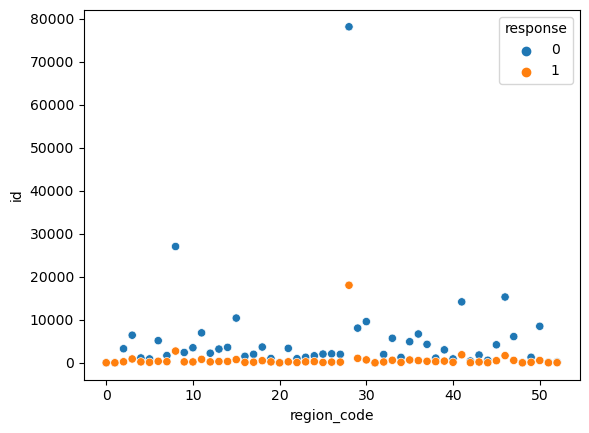

In [24]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

## 4.2. Bivariate Analysis

#### 1. Male customers have more damaged vehicles

In [25]:
H_1 = pd.crosstab(df4['gender'], df4['vehicle_damage'])
H_1['percentage %'] = round(H_1[1]/(H_1[1]+H_1[0])*100, 2)
H_1

vehicle_damage,0,1,percentage %
gender,,,
Female,82636,64079,43.68
Male,78797,89937,53.30


**True** 53% Male vs 44% Female



#### 2. Male customers are more interested in buy vehicle insurance

In [26]:
H_2 = pd.crosstab(df4['gender'], df4['response'])
H_2['percentage %'] = round(H_2[1]/(H_2[1]+H_2[0])*100, 2)
H_2

response,0,1,percentage %
gender,,,
Female,131981,14734,10.04
Male,145387,23347,13.84


**True** 14% Male vs 10% Female


#### 3. Customers that pay less annual premium are more interested in buy vehicle insurance


C:\Users\leona\AppData\Local\Temp\ipykernel_7816\3955845358.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


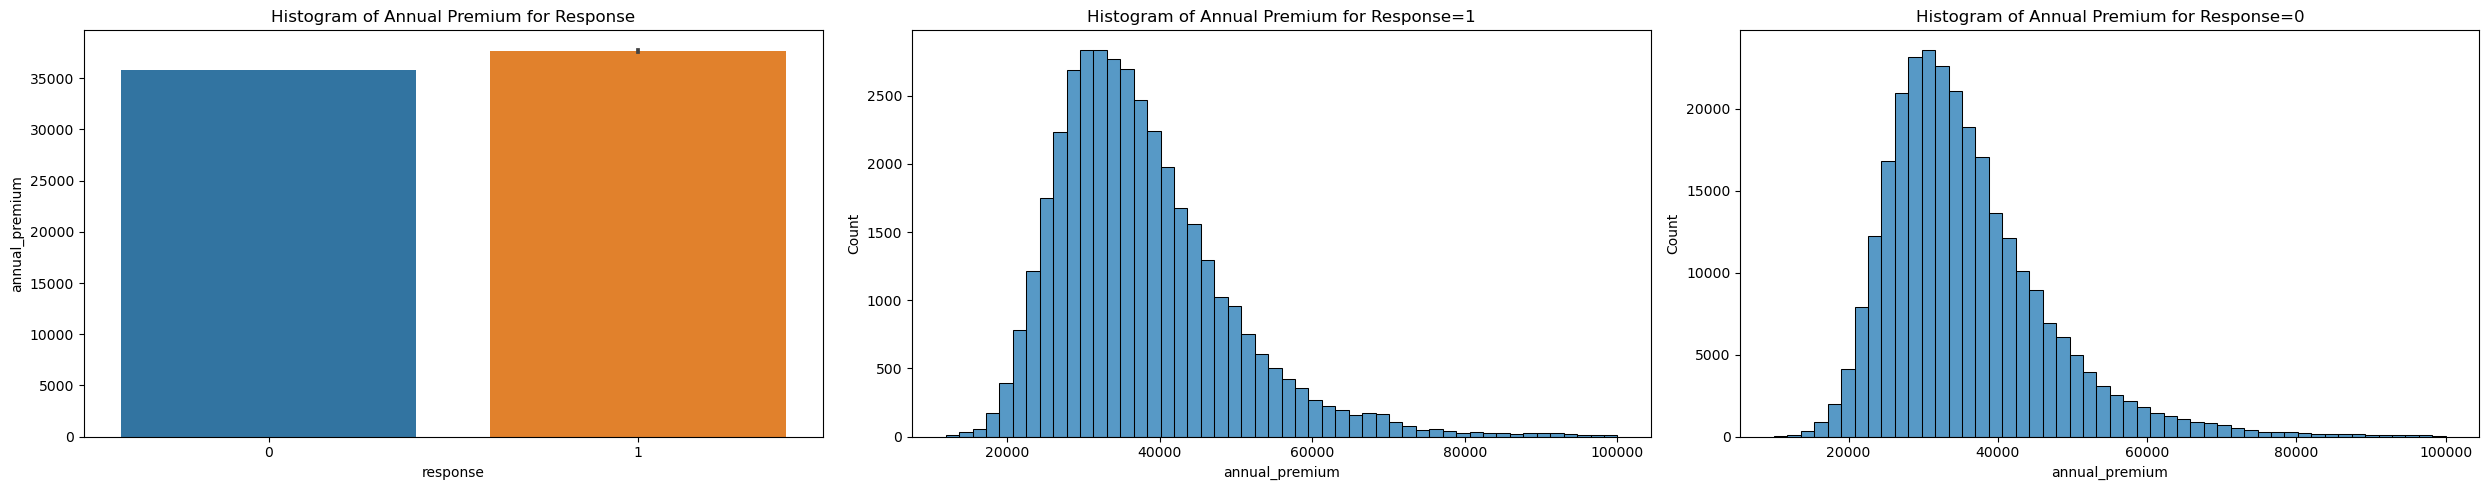

In [27]:
no_buy = df4[df4['response'] == 0]
buy =    df4[df4['response'] == 1]


fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.barplot(x='response', y='annual_premium', data=df4);
plt.title('Histogram of Annual Premium for Response')

# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(x='annual_premium', bins=50, data=buy);
plt.title('Histogram of Annual Premium for Response=1')

# Subplot 3
plt.subplot(1, 3, 3)
sns.histplot(x='annual_premium', bins=50, data=no_buy);
plt.title('Histogram of Annual Premium for Response=0')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

**False** - There are no significant difference



#### 4. Long time period customers are more insterested in buy vehicle insurance


C:\Users\leona\AppData\Local\Temp\ipykernel_7816\4193548044.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


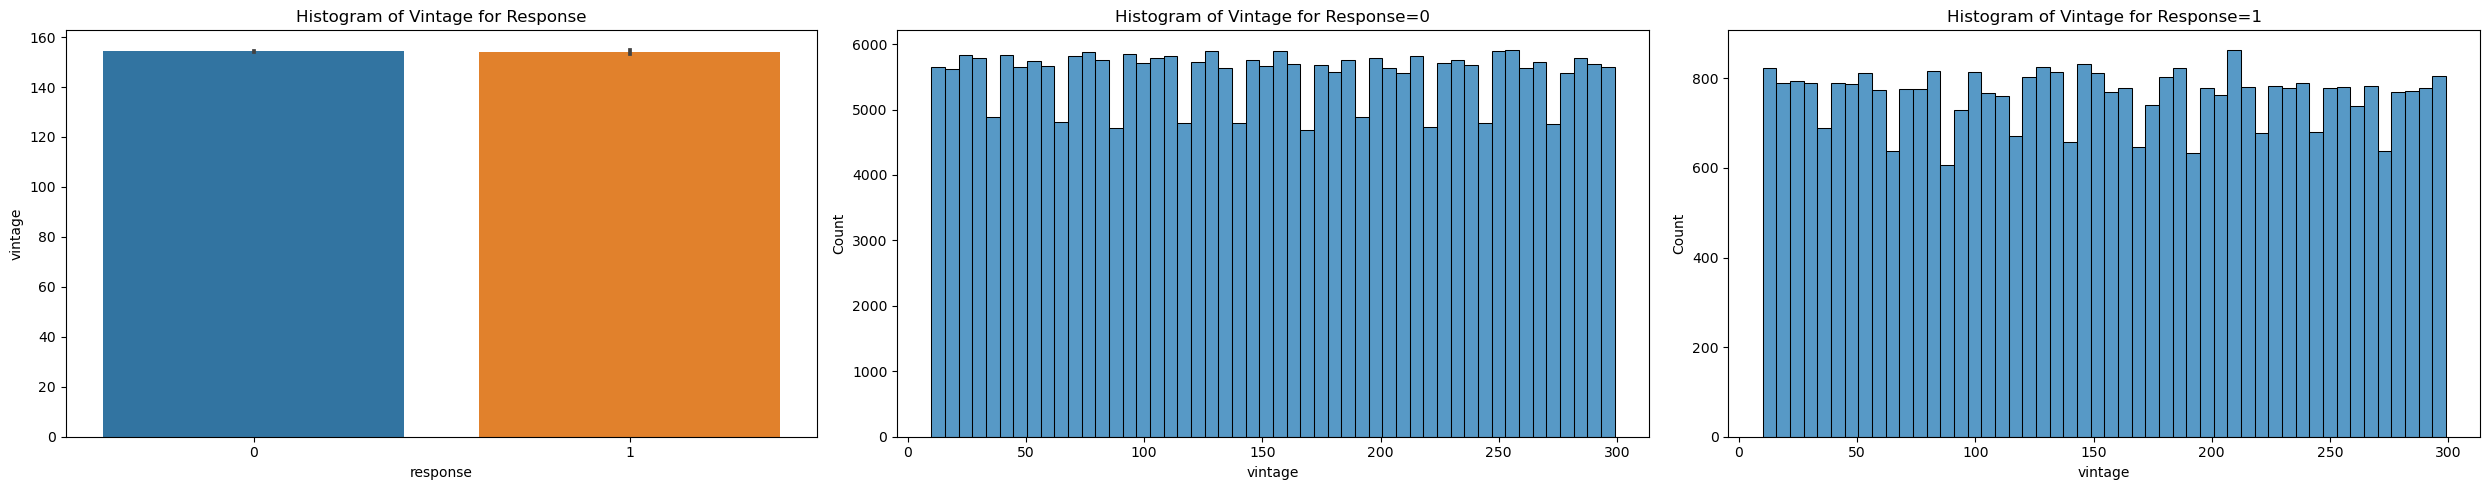

In [28]:
fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.barplot(x='response', y='vintage', data=df4);
plt.title('Histogram of Vintage for Response')

# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(x='vintage', bins=50, data=no_buy);
plt.title('Histogram of Vintage for Response=0')

# Subplot 3
plt.subplot(1, 3, 3)
sns.histplot(x='vintage', bins=50, data=buy);
plt.title('Histogram of Vintage for Response=1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

**False** - There are no significant difference

#### 5. Customers older than 40 are more interested in buy vehicle insurance


C:\Users\leona\AppData\Local\Temp\ipykernel_7816\1215352769.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


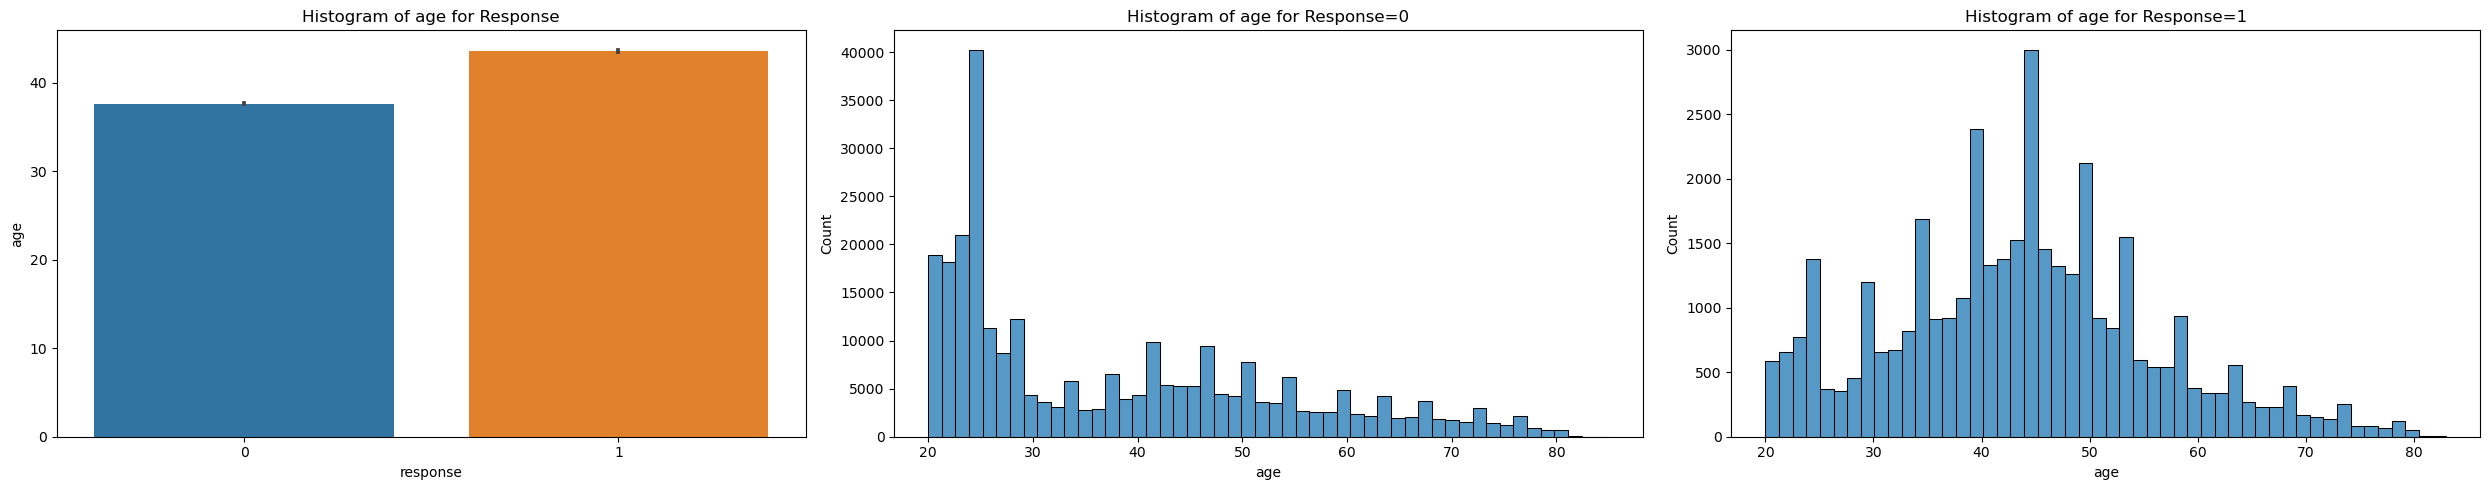

In [29]:
fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.barplot(x='response', y='age', data=df4);
plt.title('Histogram of age for Response')

# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(x='age', bins=50, data=no_buy);
plt.title('Histogram of age for Response=0')

# Subplot 3
plt.subplot(1, 3, 3)
sns.histplot(x='age', bins=50, data=buy);
plt.title('Histogram of age for Response=1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
aux2 = df4.copy()
aux2['age_test'] = aux2['age'].apply(lambda x: 'over_40' if x>40 else 'under_40')

aux3 = pd.crosstab(aux2['age_test'], aux2['response'])
aux3['percentage %'] = round(aux3[1]/(aux3[1]+aux3[0])*100, 2)
aux3

response,0,1,percentage %
age_test,,,
over_40,109465,23179,17.47
under_40,167903,14902,8.15


**True** 17% over 40 vs 8% under 40 

#### 6. Customers with damaged vehicles are more interested in buy vehicle insurance

In [31]:
H_6 = pd.crosstab(df4['vehicle_damage'], df4['response'])
H_6['percentage %'] = round(H_6[1]/(H_6[1]+H_6[0])*100, 2)
H_6

response,0,1,percentage %
vehicle_damage,,,
0,160763,670,0.42
1,116605,37411,24.29


**True** 24% of customers with damaged vehicle are interested vs 0.4% of customers whitout damage

#### 7. Customers with newer vehicles are more interested in buy vehicle insurance


In [32]:
H_7 = pd.crosstab(df4['vehicle_age'], df4['response'])
H_7['percentage %'] = round(H_7[1]/(H_7[1]+H_7[0])*100, 2)
H_7

response,0,1,percentage %
vehicle_age,,,
below_1_year,137861,5994,4.17
between_1_2_year,130381,28017,17.69
over_2_years,9126,4070,30.84


**False** - 30% of customers with vechicles older than 2 years are interested vs 17% between 1 to 2 year vs 4% below 1 year. PS: number of customers with vehicles within 1 to 2 years old is much greater.


#### 8. Customers without driver license have less interest in buy vehicle insurance


In [33]:
H_8 = pd.crosstab(df4['driving_license'], df4['response'])
H_8['percentage %'] = round(H_8[1]/(H_8[1]+H_8[0])*100, 2)
H_8

response,0,1,percentage %
driving_license,,,
0,652,34,4.96
1,276716,38047,12.09


**True** - 5% of customers without license are interested vs 12% of customers with license.

#### 9. Customers region code have no influence in the interest they have in buying vehicle insurance

In [34]:
H_9_1 = df4[['region_code', 'response']].groupby('region_code').sum().reset_index()
H_9_2 = df4[['region_code', 'id']].groupby('region_code').count().reset_index()
H_9 = pd.merge(H_9_1, H_9_2, on='region_code', how='left')
H_9['percentage'] = H_9['response']/H_9['id']
H_9 = H_9.sort_values(by='percentage', ascending=False)
H_9.head()

,region_code,response,id,percentage
1,1.0,2,3,0.666667
0,0.0,9,21,0.428571
48,48.0,4,10,0.400000
20,20.0,3,8,0.375000
31,31.0,1,4,0.250000


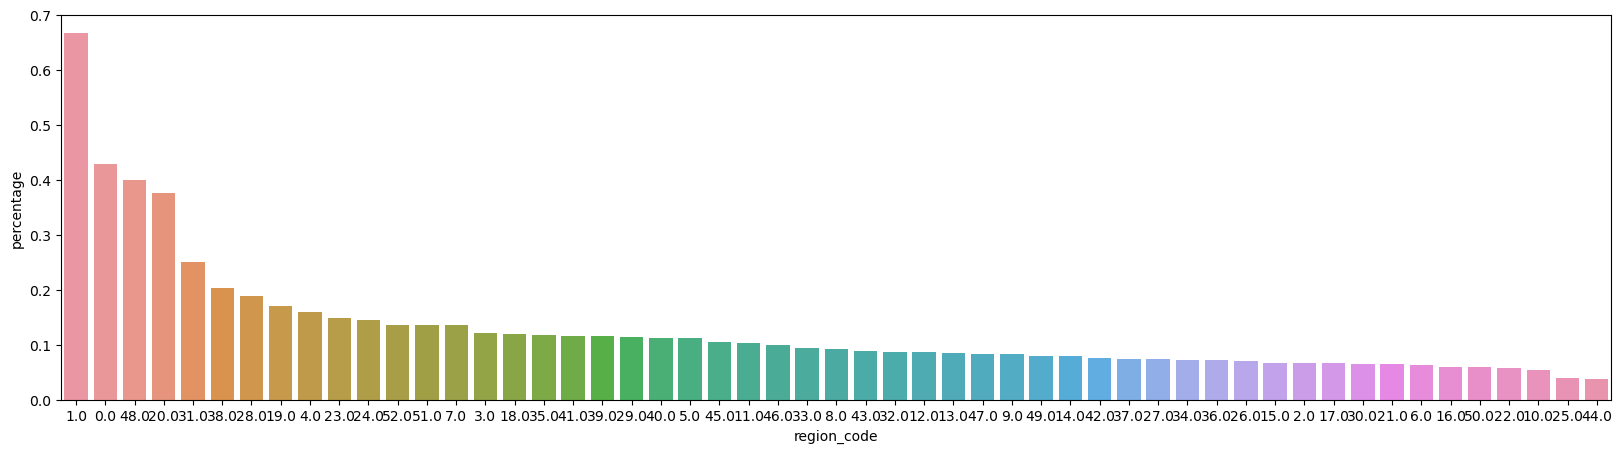

In [35]:
plt.subplots(figsize=(20, 5))
sns.barplot(x='region_code', y='percentage', data=H_9, order=H_9.region_code);

**False** - There is influence

#### 10. Customers policy_sales_channel have no influence in the interest they have in buying vehicle insurance

In [36]:
H_10_1 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
H_10_2 = df4[['policy_sales_channel', 'id']].groupby('policy_sales_channel').count().reset_index()
H_10 = pd.merge(H_10_1, H_10_2, on='policy_sales_channel', how='left')
H_10['percentage'] = H_10['response']/H_10['id']
H_10 = H_10.sort_values(by='percentage', ascending=False)
H_10.head()

,policy_sales_channel,response,id,percentage
114,123.0,1,1,1.000000
40,43.0,1,1,1.000000
94,101.0,2,5,0.400000
96,103.0,3,8,0.375000
7,9.0,4,11,0.363636


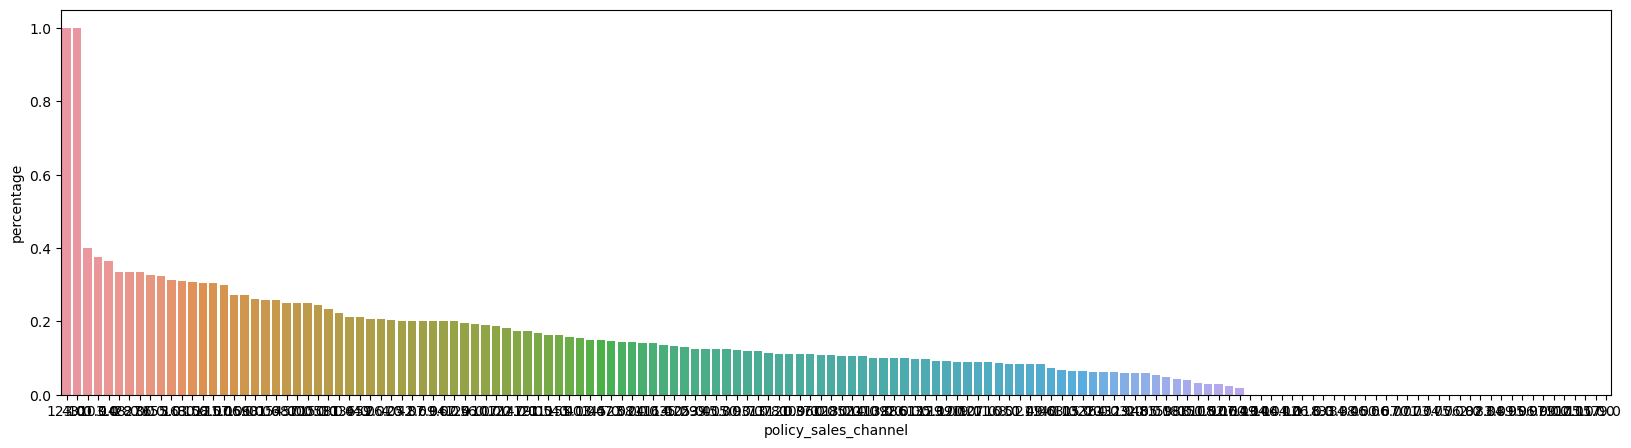

In [37]:
# H_10 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
# sns.barplot(x='response', y='policy_sales_channel', data=H_10);

plt.subplots(figsize=(20, 5))
sns.barplot(x='policy_sales_channel', y='percentage', data=H_10, order=H_10.policy_sales_channel);

**False** - There is influence



### 4.2.1. Summary of Hypotesis

In [38]:
tab = [['Hypotesis', 'Conclusion', 'Relevance'],
       ['H1 - Male customers have more damaged vehicles', 'True', 'Medium'],
       ['H2 - Male customers are more interested in buy vehicle insurance', 'True', 'Medium'],
       ['H3 - Customers that pay less annual premium are more interested in buy vehicle insurance', 'False', 'Medium'],
       ['H4 - Long time period customers are more insterested in buy vehicle insurance', 'False', 'Medium'],
       ['H5 - Customers older than 40 are more interested in buy vehicle insurance', 'True', 'High'],
       ['H6 - Customers with damaged vehicles are more interested in buy vehicle insurance', 'True', 'High'],
       ['H7 - Customers with newer vehicles are more interested in buy vehicle insurance', 'True', 'Medium'],
       ['H8 - Customers without driver license have less interest in buy vehicle insurance', 'True', 'High'],
       ['H9 - Customers region code have no influence in the interest they have in buying vehicle insurance', 'False', 'High'],
       ['H10 - Customers policy_sales_channel have no influence in the interest they have in buying vehicle insurance', 'False', 'High']]
print(tabulate(tab, headers='firstrow'))

Hypotesis                                                                                                     Conclusion    Relevance
------------------------------------------------------------------------------------------------------------  ------------  -----------
H1 - Male customers have more damaged vehicles                                                                True          Medium
H2 - Male customers are more interested in buy vehicle insurance                                              True          Medium
H3 - Customers that pay less annual premium are more interested in buy vehicle insurance                      False         Medium
H4 - Long time period customers are more insterested in buy vehicle insurance                                 False         Medium
H5 - Customers older than 40 are more interested in buy vehicle insurance                                     True          High
H6 - Customers with damaged vehicles are more interested in buy vehicle insur

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

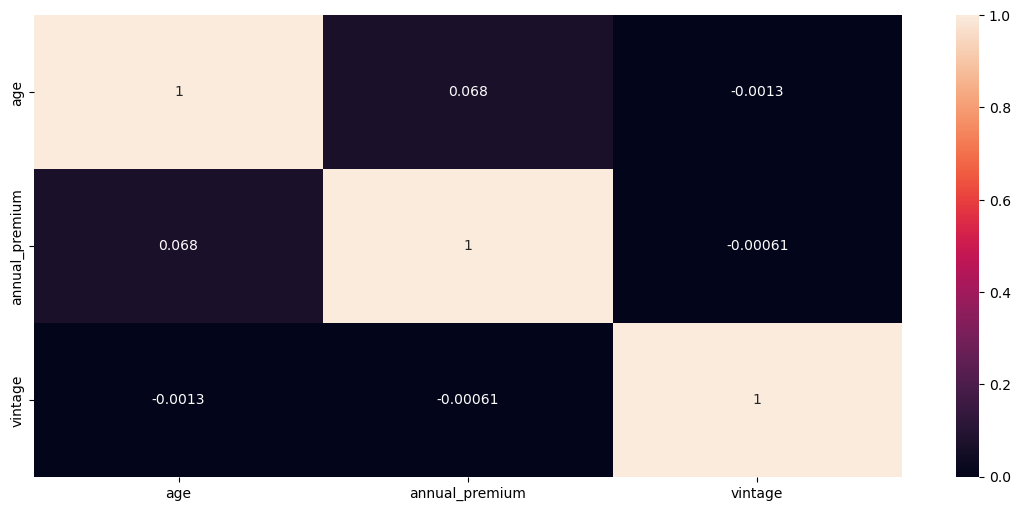

In [39]:
correlation = num_attributes.corr(method='pearson')

fig = plt.figure(figsize = (14, 6)) 
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

Para ver a correlação entre as variaveis categoricas vamos usar o [Cramér's V]('https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V')



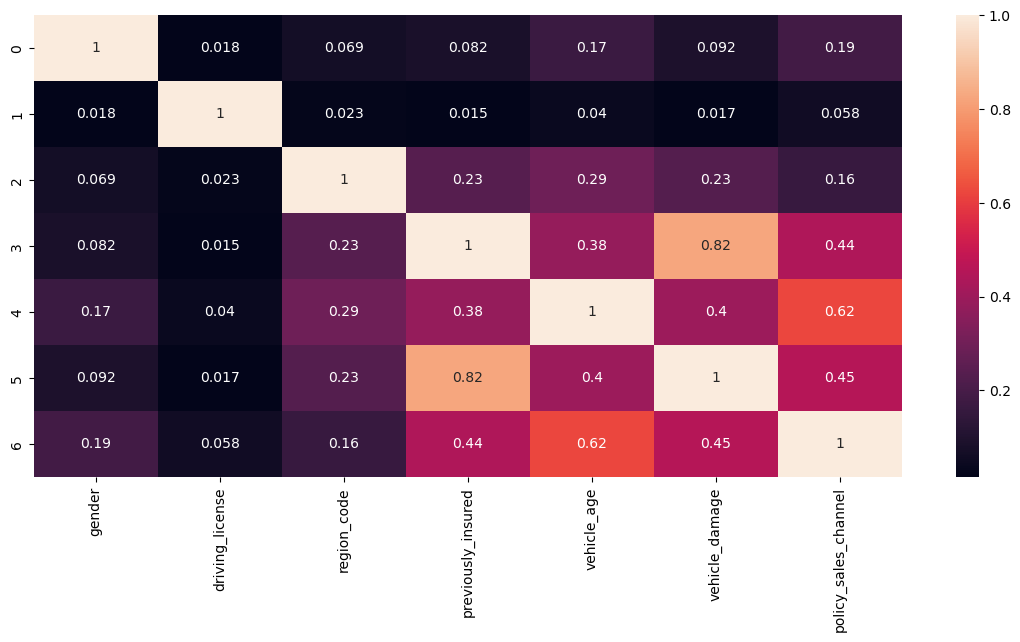

In [40]:
fig = plt.figure(figsize = (14, 6)) 
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

# 5.0 Data Preparation

This is a way of placing variables that have a normal distribution or something close to it on a scale from 0 to 1.
As we saw, the variable annual_premium has a normal distribution. This way, we will apply StandardScaler()

In [41]:
df5 = df4.copy()

In [42]:
# split data
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

# training data
df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Normalization 

This is a way of placing variables that have a normal distribution or something close to it on a scale from 0 to 1.
As we saw, the variable annual_premium has a normal distribution. This way, we will apply StandardScaler()

In [43]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

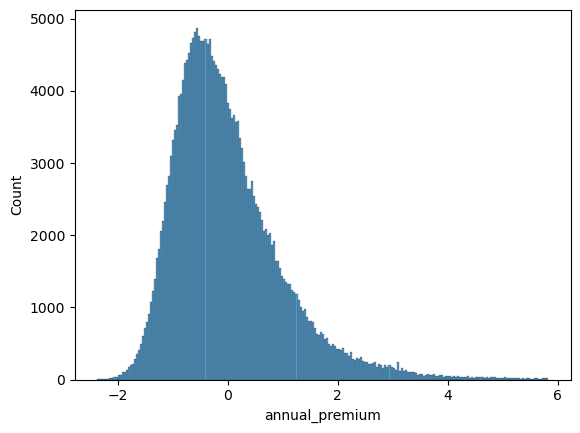

In [44]:
aux00 = df5.loc[:, 'annual_premium']
sns.histplot( aux00 );

## 5.2. Rescaling

This is a way of placing variables that do not have a normal distribution on a scale of 0 to 1. To do this, we will use MinMaxScaler()

In [45]:
mms = pp.MinMaxScaler()  # Usado quando os outliers não são tão relevantes

# age
df5['age'] = mms.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms.fit_transform(df5[['vintage']].values)

C:\Users\leona\AppData\Local\Temp\ipykernel_7816\1311658133.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


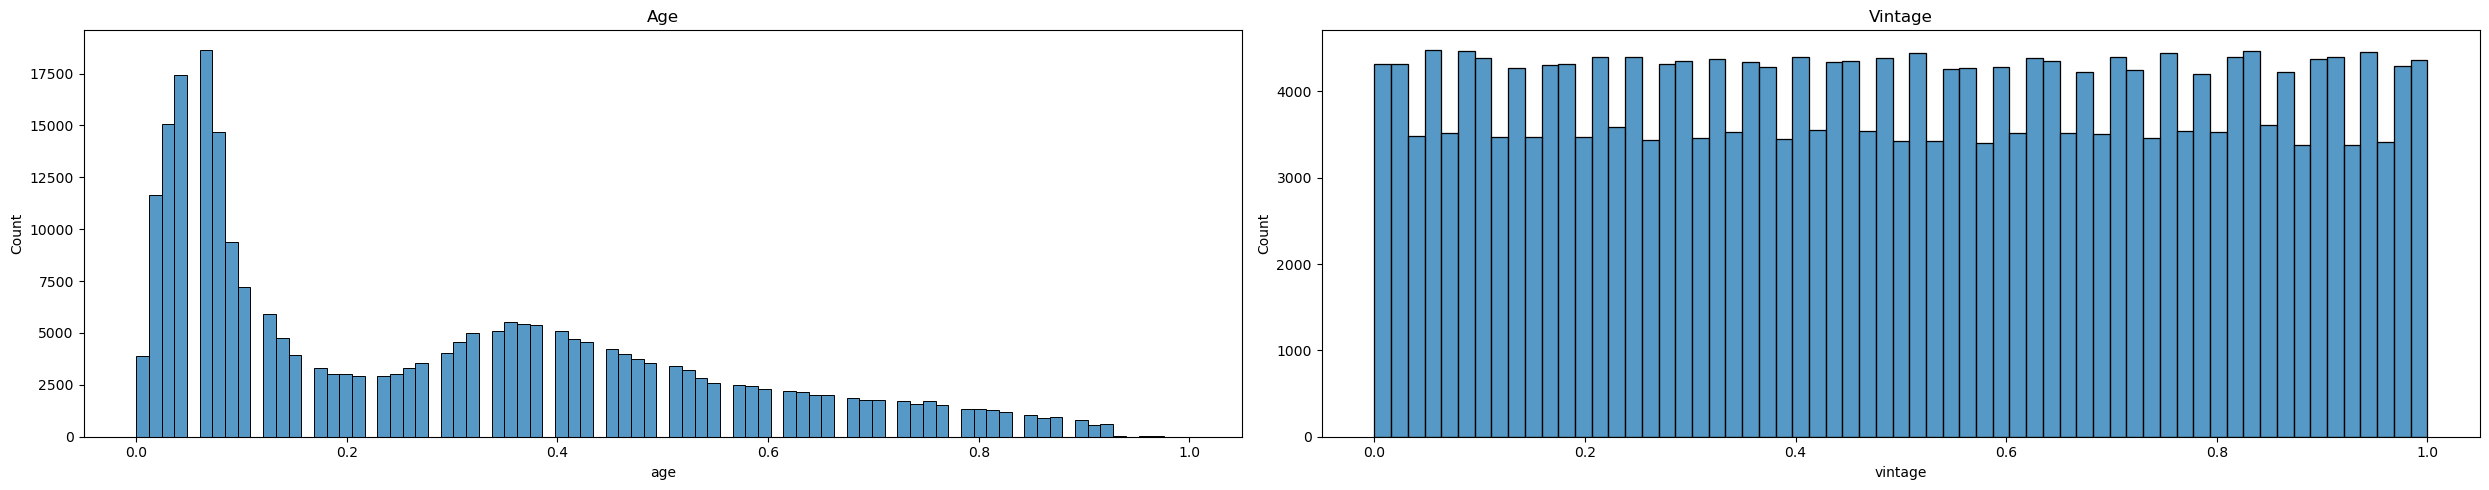

In [46]:
fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 2, 1)
aux00 = df5.loc[:, 'age']
sns.histplot( aux00 )
plt.title('Age')

# Subplot 2
plt.subplot(1, 2, 2)
aux00 = df5.loc[:, 'vintage']
sns.histplot( aux00 )
plt.title('Vintage')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

## 5.3. Encoding

Let's transform categorical data into numerical data.

In [47]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding 
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_encode_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_encode_policy_sales_channel)

C:\Users\leona\AppData\Local\Temp\ipykernel_7816\743743.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)


## 5.4. Validation Preparation

In [48]:
## Normalization

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

In [49]:
## Rescaling

# age
x_validation.loc[:, 'age'] = mms.transform(x_validation[['age']].values)

# vintage
x_validation.loc[:, 'vintage'] = mms.transform(x_validation[['vintage']].values)

In [50]:
## Encoding

# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_encode_policy_sales_channel)

# fillna
x_validation = x_validation.fillna(0)

C:\Users\leona\AppData\Local\Temp\ipykernel_7816\2356942927.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)


# 6.0 Feature Selection

In [51]:
df6 = df5.copy()

## 6.1 Features Importance

In [52]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=1)
# forest = RandomForestClassifier(n_estimators=250, random_state=0, n_jobs=1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

Feature Ranking: 
                        feature  importance
0                annual_premium    0.273337
0                       vintage    0.248396
0                           age    0.156266
0                   region_code    0.103472
0                vehicle_damage    0.071712
0            previously_insured    0.059088
0          policy_sales_channel    0.057371
0      vehicle_age_below_1_year    0.015431
0  vehicle_age_between_1_2_year    0.006758
0                        gender    0.004502
0      vehicle_age_over_2_years    0.003189
0               driving_license    0.000476


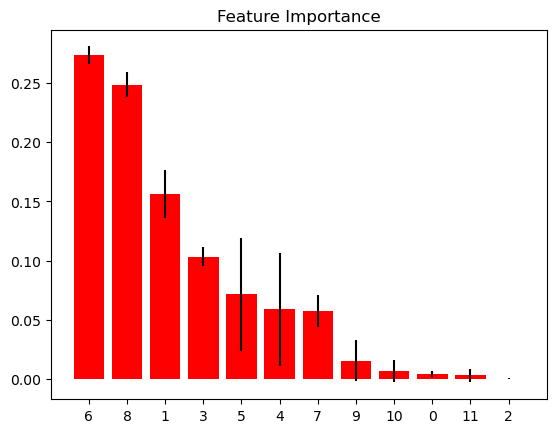

In [53]:
# Feature Importance Calculation:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature Ranking: ')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), 
        importances[indices], 
        color='r', 
        yerr=std[indices], 
        align='center')
plt.xticks(range(x_train_n.shape[1]), 
           indices) 
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.2 Hypothesis Conclusion (from EDA)

In [54]:
print(tabulate(tab, headers='firstrow'))

Hypotesis                                                                                                     Conclusion    Relevance
------------------------------------------------------------------------------------------------------------  ------------  -----------
H1 - Male customers have more damaged vehicles                                                                True          Medium
H2 - Male customers are more interested in buy vehicle insurance                                              True          Medium
H3 - Customers that pay less annual premium are more interested in buy vehicle insurance                      False         Medium
H4 - Long time period customers are more insterested in buy vehicle insurance                                 False         Medium
H5 - Customers older than 40 are more interested in buy vehicle insurance                                     True          High
H6 - Customers with damaged vehicles are more interested in buy vehicle insur

## 6.3 Feature Selection Conclusion

Após as analises decidimos por deixar todas as features. 

# 7.0 Machine Learning Modeling

In [55]:
df7 = df6.copy()

In [56]:

# cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

cols_selected = ['gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium',
                 'policy_sales_channel', 'vintage', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years']

# treino 
x_train = df7[cols_selected]
y_train = y_train.copy()

# validação
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1.  k-nearest neighbors algorithm  (KNN)

Se a curva associada a uma classe (class 1) está mais acima em relação à linha de referência aleatória e à curva associada à outra classe (class 0), isso sugere que o modelo está melhor em identificar positivos verdadeiros para essa classe. Em outras palavras, o modelo está mais preciso ao identificar instâncias dessa classe em comparação com a outra.

A diferença vertical entre as curvas de ganho cumulativo para as duas classes reflete a discrepância no desempenho do modelo em identificar verdadeiros positivos para essas classes. Quanto maior a diferença, melhor o modelo está em distinguir as duas classes.

A linha de referência aleatória serve como uma linha de base que representa o desempenho esperado de um classificador aleatório. Se a curva para uma classe específica está consideravelmente acima dessa linha, isso indica que o modelo está oferecendo melhorias significativas em relação a uma escolha aleatória para essa classe.

In [ ]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - poder de GENERALIZACAO
yhat_knn = knn_model.predict_proba(x_val)

In [120]:
# compute precision at k
precision_knn = precision_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_knn, k_percentage=0.40)
print('precision_knn: ', round(precision_knn, 5))

# compute recall at k
recall_knn = recall_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_knn, k_percentage=0.20)
print('recall_knn: ', round(recall_knn, 5))

precision_knn:  0.25811
recall_knn:  0.47879


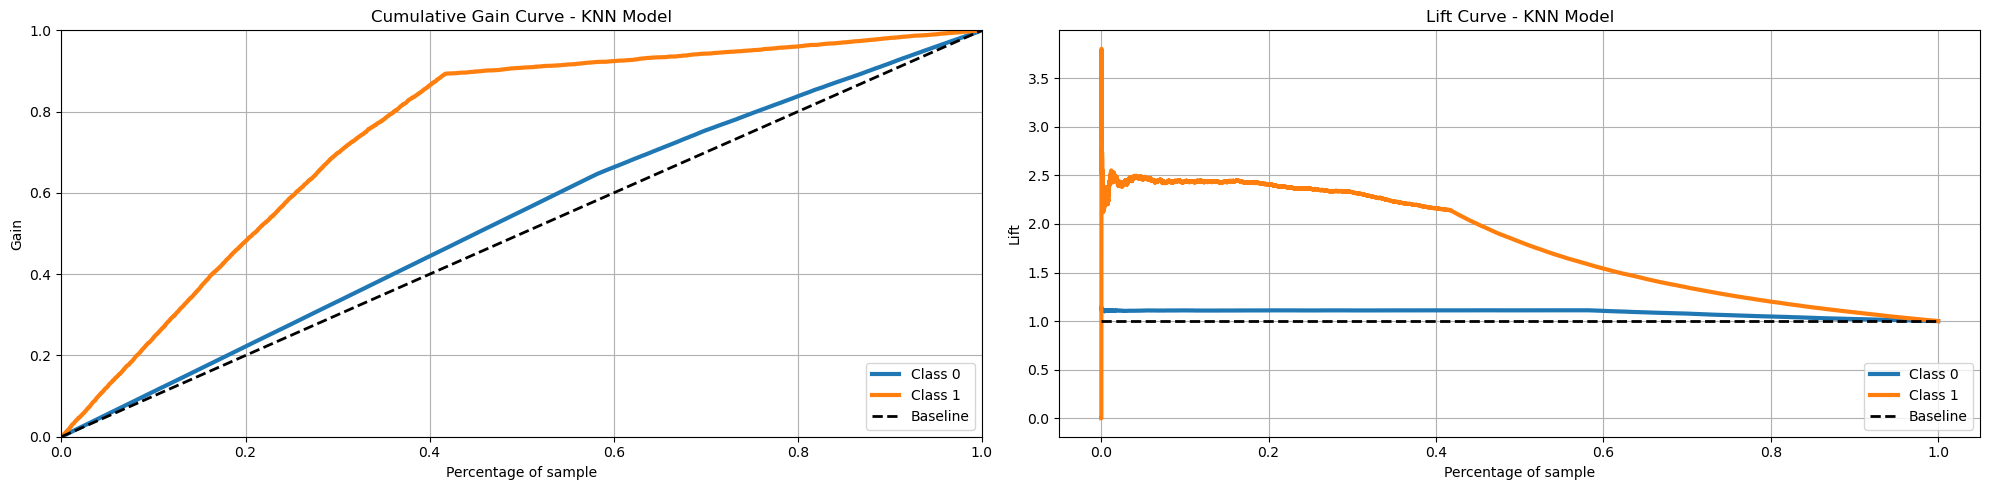

In [80]:
# Figura

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Subplot 1 - Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve - KNN Model')

# Subplot 2 - Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=axes[1])
axes[1].set_title('Lift Curve - KNN Model')

# Adjust layout
plt.tight_layout()
plt.show()


## 7.2. Logistic Regression

In [105]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

c:\Users\leona\anaconda3\envs\dsprod\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [119]:
# compute precision at k
precision_lr = precision_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_lr, k_percentage=0.40)
print('precision_lr: ', round(precision_lr, 5))

# compute recall at k
recall_lr = recall_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_lr, k_percentage=0.20)
print('recall_lr: ', round(recall_lr, 5))

precision_lr:  0.27436
recall_lr:  0.51366


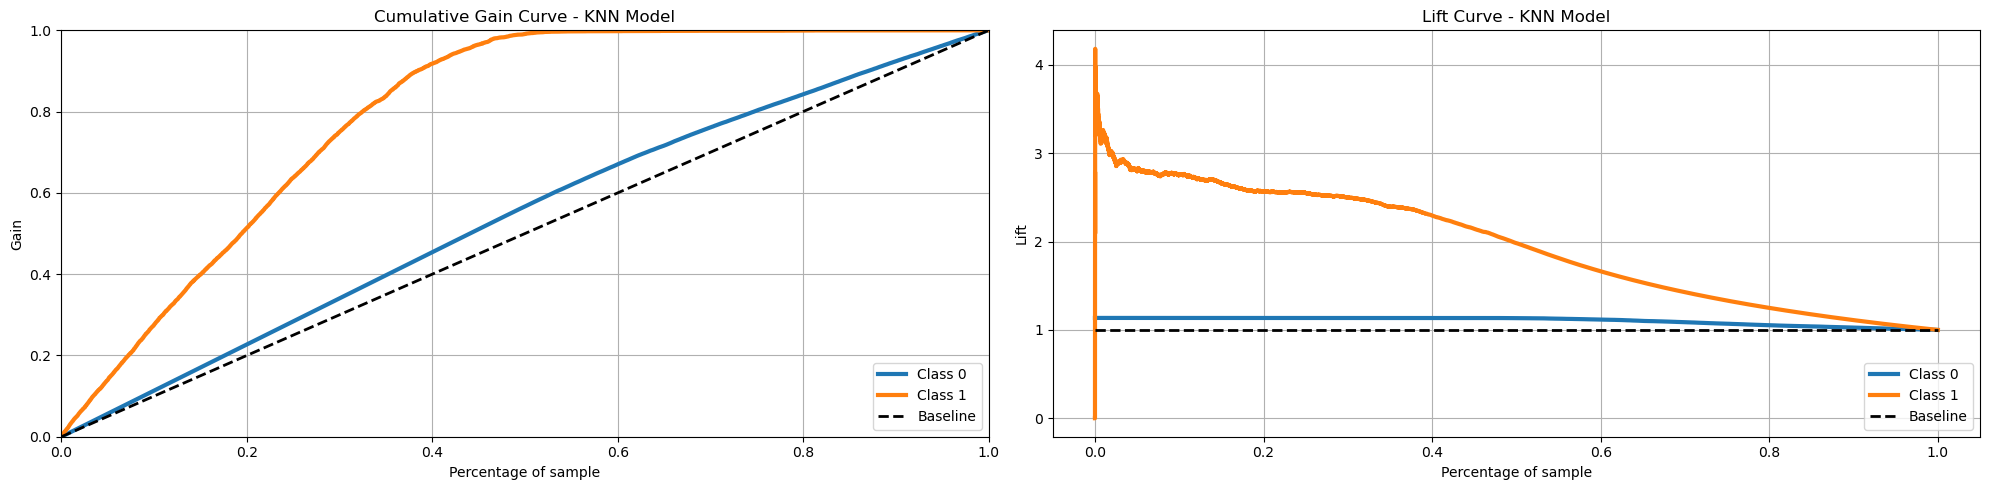

In [121]:
# Figura

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Subplot 1 - Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve - KNN Model')

# Subplot 2 - Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax=axes[1])
axes[1].set_title('Lift Curve - KNN Model')

# Adjust layout
plt.tight_layout()
plt.show()

## 7.3. Gradiant Boosting Classifier

In [107]:
## model definition
gdr_model = en.GradientBoostingClassifier(n_estimators=100, random_state=42)

# model training
gdr_model.fit(x_train, y_train)

# model prediction
yhat_gdr = gdr_model.predict_proba(x_val)


In [117]:
# compute precision at k
precision_gdr = precision_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_gdr, k_percentage=0.40)
print('precision_gdr: ', round(precision_gdr, 5))

# compute recall at k
recall_gdr = recall_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_gdr, k_percentage=0.20)
print('recall_gdr: ', round(recall_gdr, 5))

precision_gdr:  0.27943
recall_gdr:  0.46394


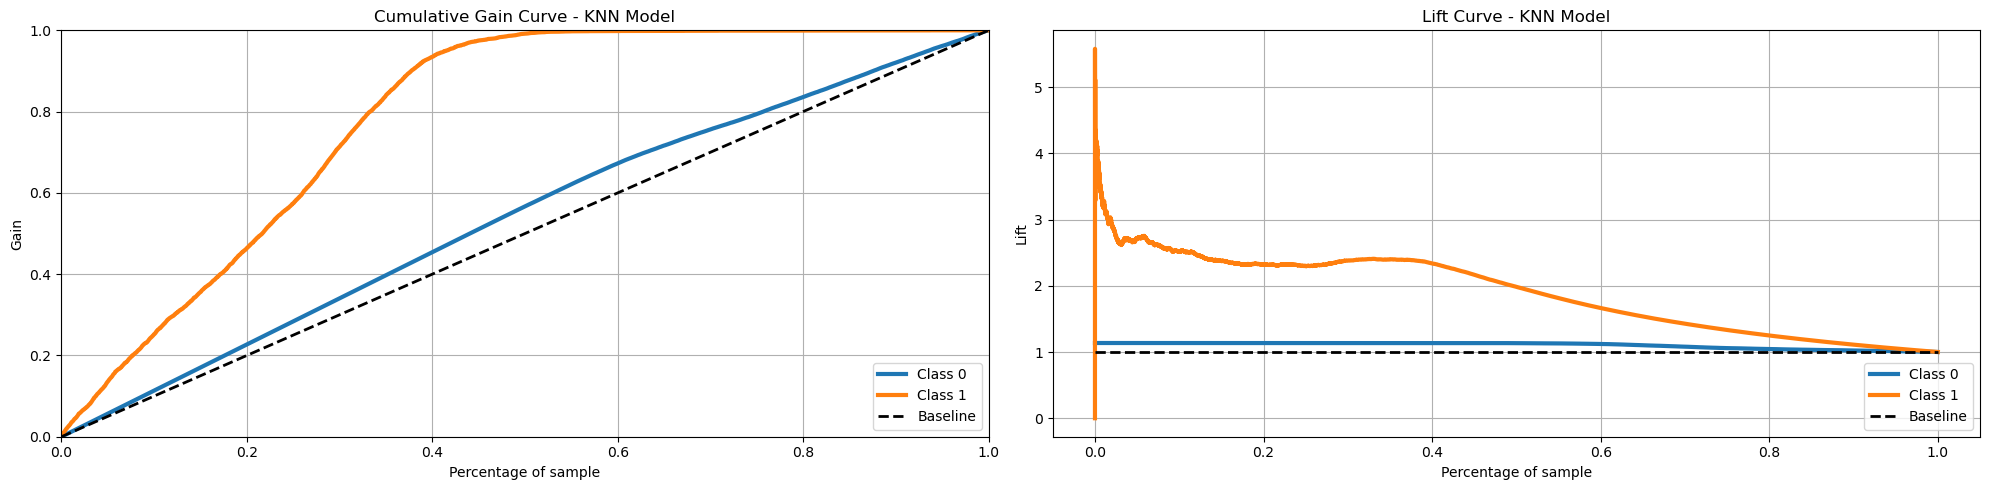

In [122]:
# Figura

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Subplot 1 - Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_gdr, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve - KNN Model')

# Subplot 2 - Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_gdr, ax=axes[1])
axes[1].set_title('Lift Curve - KNN Model')

# Adjust layout
plt.tight_layout()
plt.show()

## 7.4. Random Forest Classifier

In [109]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=None)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(x_val)

In [116]:
# compute precision at k
precision_rf = precision_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_rf, k_percentage=0.40)
print('precision_rf: ', round(precision_rf, 5))

# compute recall at k
recall_rf = recall_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_rf, k_percentage=0.20)
print('recall_rf: ', round(recall_rf, 5))

precision_rf:  0.27186
recall_rf:  0.47839


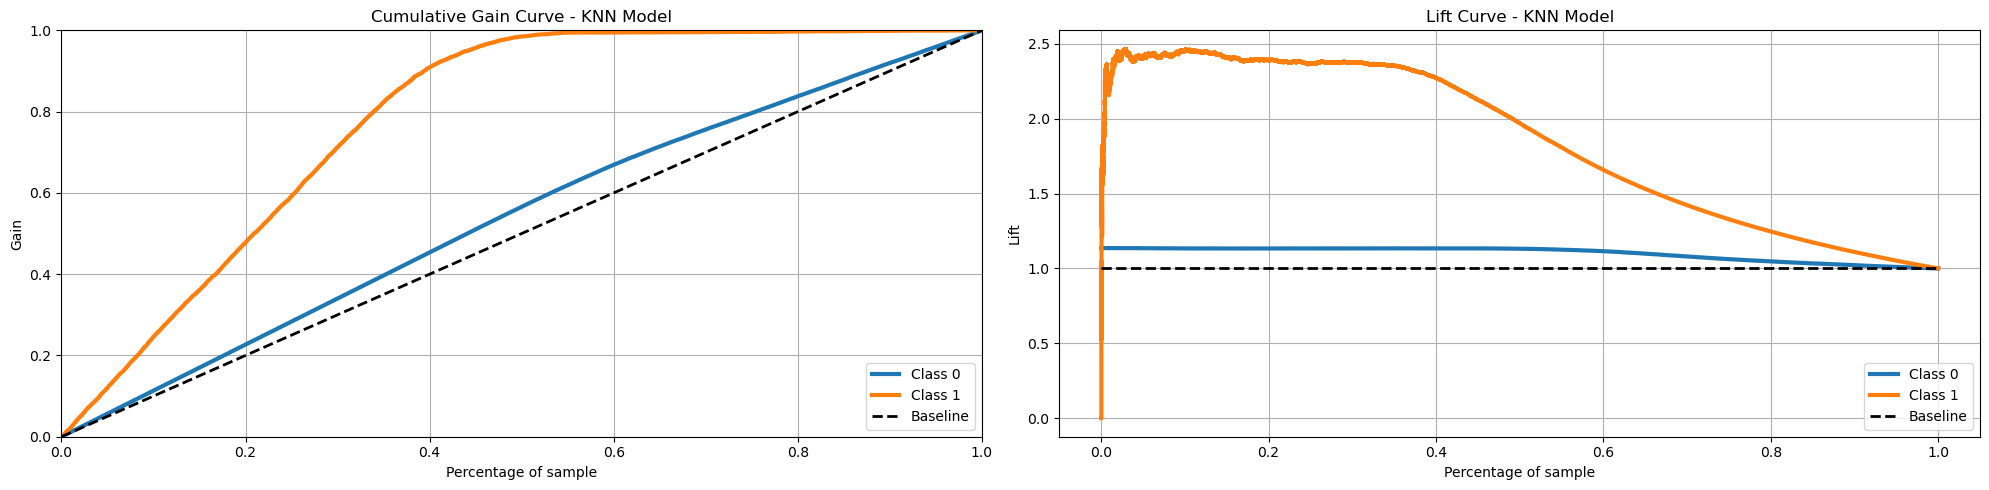

In [123]:
# Figura

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Subplot 1 - Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve - KNN Model')

# Subplot 2 - Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax=axes[1])
axes[1].set_title('Lift Curve - KNN Model')

# Adjust layout
plt.tight_layout()
plt.show()

## 7.5. XGBoost Classifier

In [111]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit(x_train,y_train.values.ravel())

# model prediction
yhat_xgb = xgb_model.predict_proba(x_val)


In [113]:
# compute precision at k
precision_xgb = precision_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_xgb, k_percentage=0.40)
print('precision_xgb: ', round(precision_xgb, 5))

# compute recall at k
recall_xgb = recall_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_xgb, k_percentage=0.20)
print('recall_xgb: ', round(recall_xgb, 5))

precision_xgb:  0.27785
recall_xgb:  0.46924


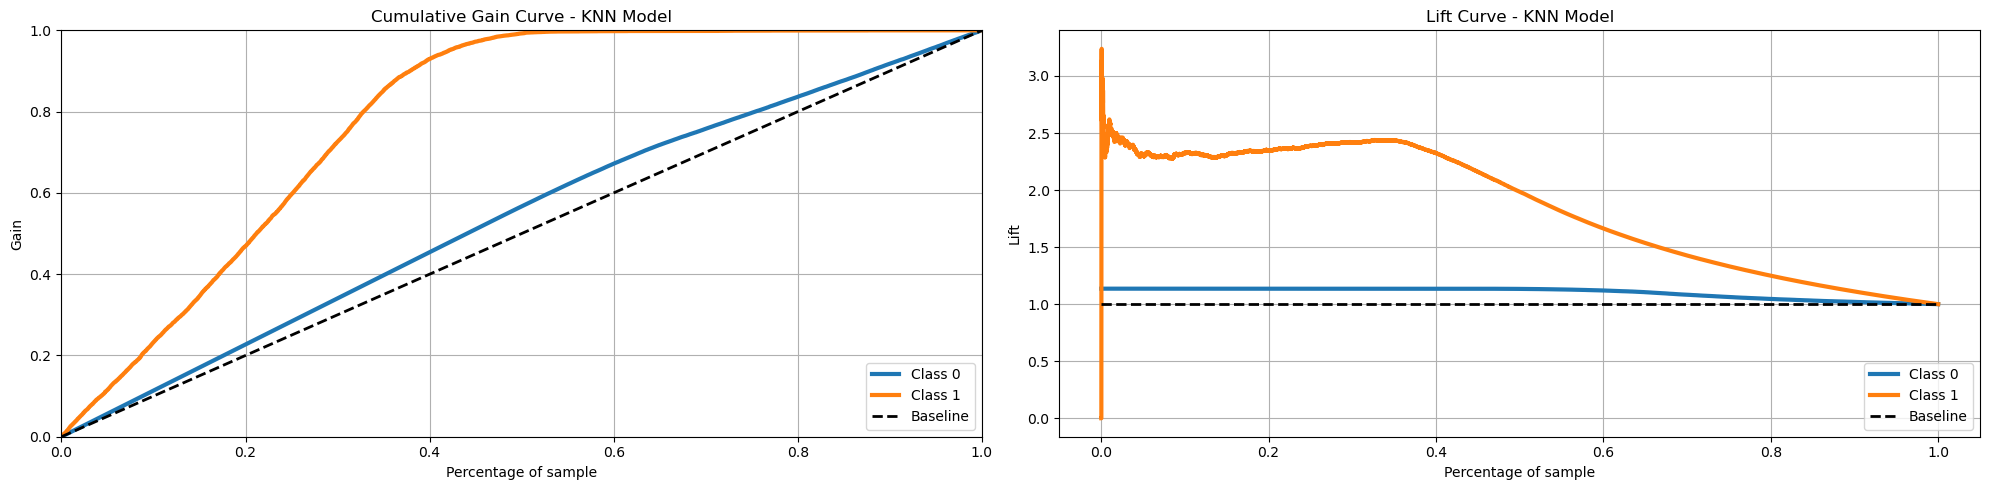

In [124]:
# Figura

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Subplot 1 - Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve - KNN Model')

# Subplot 2 - Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax=axes[1])
axes[1].set_title('Lift Curve - KNN Model')

# Adjust layout
plt.tight_layout()
plt.show()

## 7.6. Extra Trees

In [114]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# model training
et_model.fit(x_train, y_train)

# model prediction
yhat_et = et_model.predict_proba(x_val)

In [115]:
# compute precision at k
precision_et = precision_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_et, k_percentage=0.40)
print('precision_et: ', round(precision_et, 5))

# compute recall at k
recall_et = recall_at_k(x_val=x_validation, y_val=y_validation, yhat=yhat_et, k_percentage=0.20)
print('recall_et: ', round(recall_et, 5))

precision_et:  0.2704
recall_et:  0.47348


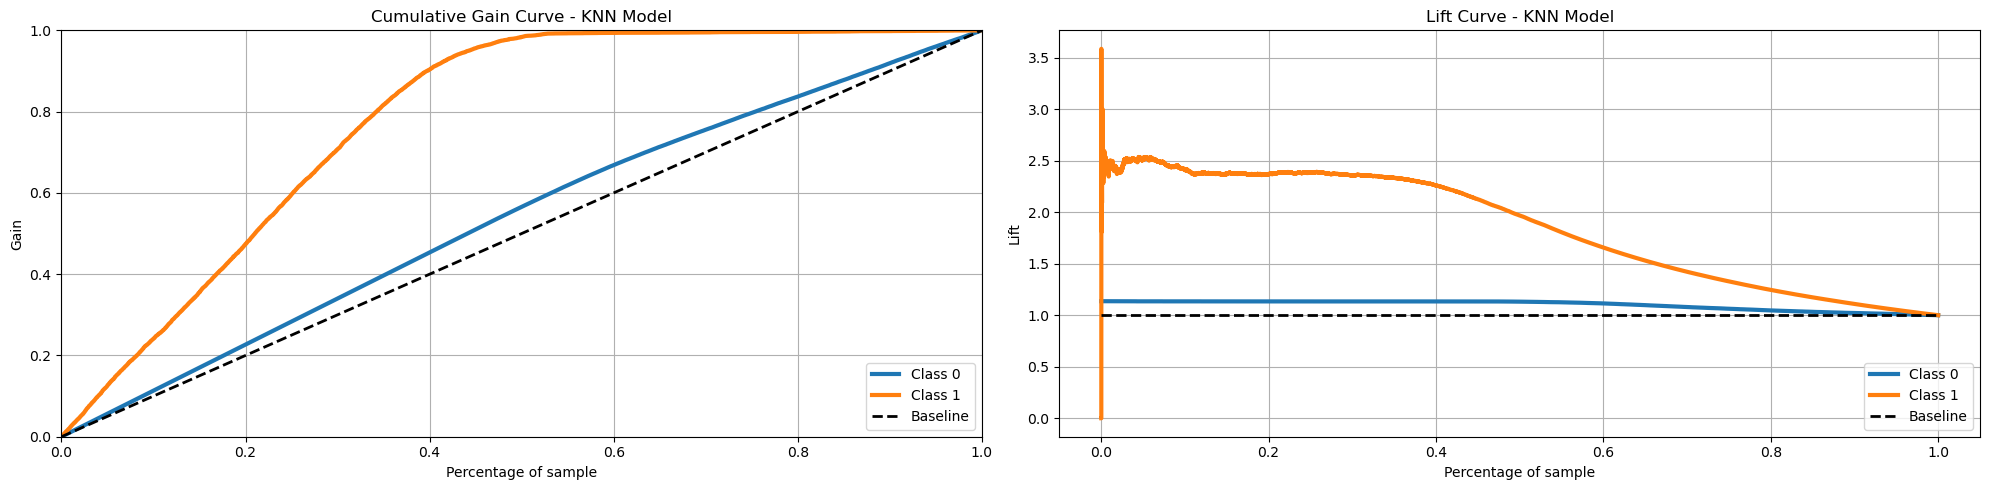

In [128]:
# Figura

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Subplot 1 - Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax=axes[0])
axes[0].set_title('Cumulative Gain Curve - KNN Model')

# Subplot 2 - Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_et, ax=axes[1])
axes[1].set_title('Lift Curve - KNN Model')

# Adjust layout
plt.tight_layout()
plt.show()

# 8.0 Model Performance

## 8.1. Comparing Models

In [129]:
models = ['knn', 'logistic_regression', 'gradient_boosting', 'random_forest', 'xgboost', 'extra_trees']
top_k = pd.DataFrame(models, columns=['models'])
top_k['precision_at_k'] = [precision_knn, precision_lr, precision_gdr, precision_rf, precision_xgb, precision_et]
top_k['recall_at_k'] = [recall_knn, recall_lr, recall_gdr, recall_rf, recall_xgb, recall_et]
top_k

,models,precision_at_k,recall_at_k
0,knn,0.258113,0.478785
1,logistic_regression,0.274359,0.513657
2,gradient_boosting,0.279431,0.463935
3,random_forest,0.271863,0.478388
4,xgboost,0.277846,0.469239
5,extra_trees,0.270397,0.473482
